[![colab image](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/astro-informatics/harmonic/blob/main/notebooks/gaussian_sddr_exmple.ipynb)

<center><img src="https://raw.githubusercontent.com/astro-informatics/harmonic/fa99200ddd9c942921439cfbadf30c6ede7226f3/docs/assets/harm_badge_simple.svg" width="250" height="250"/>

# [`harmonic`](https://github.com/astro-informatics/harmonic) - __SDDR__ Interactive Tutorial
---

In this interactive tutorial we demonstrate basic usage of `sddr`, using [`emcee`](https://emcee.readthedocs.io/en/stable/) as the sampler.





In [ ]:
%%capture
# Install packages
%pip install harmonic emcee nautilus-sampler getdist

In [1]:
import numpy as np
import emcee
from getdist import plots, MCSamples
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
import harmonic as hm
from nautilus import Prior, Sampler

## Notebook outline

We're going to calculate a SDDR with a simple Gaussian model

First, let's define some helper functions


In [2]:
def ln_likelihood(x, simulator, data, inv_cov):
    x = np.atleast_2d(x)
    r = data - simulator(x)
    chi2 = np.einsum("ij,ij->i", r, np.dot(inv_cov, r.T).T)
    return -0.5 * chi2


def ln_posterior(x, simulator, data, inv_cov, prior):
    """Compute the log posterior."""
    x = np.atleast_2d(x)
    ln_posterior = ln_likelihood(x, simulator, data, inv_cov) + prior.logpdf(x)
    return ln_posterior


def init_diag_cov(ndim):
    """Initialise random diagonal covariance matrix.

    Args:

        ndim: Dimension of Gaussian.

    Returns:

        double ndarray[ndim, ndim]: Covariance matrix of shape (ndim,ndim).

    """

    cov = np.zeros((ndim, ndim))
    diag_cov = np.ones(ndim)
    np.fill_diagonal(cov, diag_cov)

    return cov


def init_cov(ndim):
    """Initialise random non-diagonal covariance matrix.

    Args:

        ndim: Dimension of Gaussian.

    Returns:

        cov: Covariance matrix of shape (ndim,ndim).

    """

    cov = np.zeros((ndim, ndim))
    diag_cov = np.ones(ndim) + np.random.randn(ndim) * 0.1
    np.fill_diagonal(cov, diag_cov)
    off_diag_size = 0.5
    for i in range(ndim - 1):
        cov[i, i + 1] = (
            (-1) ** i * off_diag_size * np.sqrt(cov[i, i] * cov[i + 1, i + 1])
        )
        cov[i + 1, i] = cov[i, i + 1]

    return cov

### MCMC functions

In [3]:
def run_mcmc(
    nchains, nparams, ln_posterior, mock_simulator, data, inv_cov, prior, samples_per_chain, nburn, 
):
    pos = prior.rvs(nchains)

    sampler = emcee.EnsembleSampler(
        nwalkers=nchains,
        ndim=nparams,
        log_prob_fn=ln_posterior,
        vectorize=True,
        # moves=emcee.moves.StretchMove(),
        args=[mock_simulator, data, inv_cov, prior],
    )

    sampler.run_mcmc(pos, samples_per_chain, progress=True)

    samples = np.ascontiguousarray(sampler.chain[:, nburn:, :])
    log_prob = np.ascontiguousarray(sampler.lnprobability[:, nburn:])
    flat_samples, flat_weights = np.unique(
        sampler.get_chain(flat=True), axis=0, return_counts=True
    )
    flat_log_prob, _ = np.unique(
        sampler.get_log_prob(flat=True), axis=0, return_counts=True
    )

    samples = np.ascontiguousarray(sampler.chain[:, nburn:, :])
    log_prob = np.ascontiguousarray(sampler.lnprobability[:, nburn:])

    return flat_samples, flat_weights, flat_log_prob, samples, log_prob

### Plotting function

In [4]:
def triangle_plot(
    mc_samples,
    truth=None,
    params_to_plot=None,
    savefig=False,
    filename=None,
):
    # Triangle plot
    plt.close()
    with mpl.rc_context():
        # g = plots.getSubplotPlotter(width_inch=12)
        g = plots.getSubplotPlotter()
        g.settings.figure_legend_frame = False
        g.settings.alpha_filled_add = 0.6
        g.settings.axes_fontsize = 18
        g.settings.legend_fontsize = 18
        g.settings.lab_fontsize = 18
        if params_to_plot:
            g.triangle_plot(
                mc_samples, params=params_to_plot, filled_compare=True, normalized=True
            )
        else:
            g.triangle_plot(mc_samples, filled_compare=True, normalized=True)

        if truth is not None:
            g.add_param_markers(truth, color="black", ls="--")

        plt.subplots_adjust(hspace=0, wspace=0)

        if savefig:
            plt.savefig(filename, bbox_inches="tight")
        plt.show()

## Fix the seed


In [5]:
np.random.seed(42)

## Set priors

Can be uniform or gaussian, here we use an uncorrelated Gaussian prior


In [6]:
n_params = 5
n_nested = 2

means = np.zeros(n_params)
prior_cov = np.diag(np.ones(n_params)*2.0 ** 2)
inv_prior_cov = np.linalg.inv(prior_cov)
prior = multivariate_normal(mean=means, cov=prior_cov)
nested_prior = multivariate_normal(
    mean=means[:-n_nested], cov=prior_cov[:-n_nested, :-n_nested]
)
marginal_prior = multivariate_normal(
    mean=means[-n_nested:], cov=prior_cov[-n_nested:, -n_nested:]
)

## Create the Gaussian likelihood first 

In the case that we are considering, we will have a data vector that is 3 numbers long, and a super model with 5 parameters, and a nested model with 3 parameters.

Shared parameters are denoted as $\theta$, and the parameters that extend the nested model to the super parameter are denoted with $\eta$. These are also the nested parameters. 

The corresponding Gaussian likelihood is given by
\begin{equation}
	\mathcal{L}( \bm{d} \mid \bm{\theta}) = \frac{\exp\bigl( -\frac{1}{2} (\bm{d} - \bm{\mu}(\bm{\theta, \eta}))^\text{T} \Sigma^{-1} (\bm{d} - \bm{\mu}(\bm{\theta, \eta}) \bigr)}{(2 \pi)^{3/2}|\Sigma|^{1/2}}. 
\end{equation}

For our super model, we have
\begin{align}
	\bm{\mu}(\bm{\theta, \eta}) & = \begin{bmatrix}
                                            \theta_1 + \mathrm{arcsinh}(\theta_4)\\
                                            \arctan(\theta_2) + \eta_1 \\
                                            e^{0.5 \times \theta_3} + \eta_2
	                                        \end{bmatrix}.
\end{align}

Whilst for the nested model, we fix $\eta_1 = -2$ and $\eta_2 = 0.2$.

In [7]:
ndata = 3
cov = init_cov(ndata)
inv_cov = np.linalg.inv(cov)
 
theta_truth = np.array([0.0, -0.5, 0.5])
eta_truth = np.array([1.0, 2.0])

truth = np.concatenate((theta_truth, eta_truth))

def mock_simulator(theta):
    theta = np.atleast_2d(theta)
    model_prediction = np.zeros((theta.shape[0], ndata))
    model_prediction[:, 0] = theta[:, 0]
    model_prediction[:, 1] = np.arcsinh(theta[:, 1]) + np.arctan(theta[:, 3])
    model_prediction[:, 2] = np.exp(0.5 * theta[:, 2]) - theta[:, 4]
    return model_prediction

def nested_mock_simulator(theta):
    theta = np.atleast_2d(theta)
    model_prediction = np.zeros((theta.shape[0], ndata))
    model_prediction[:, 0] = theta[:, 0]
    model_prediction[:, 1] = np.arcsinh(theta[:, 1]) + np.arctan(eta_truth[0])
    model_prediction[:, 2] = np.exp(0.5 * theta[:, 2]) - eta_truth[1]
    return model_prediction

## Generate some fake data with Gaussian noise


In [8]:
noiseless_data = mock_simulator(truth)[0]
data = np.random.multivariate_normal(noiseless_data, cov)

## Get some posterior samples with emcee


In [9]:
nchains = 100
samples_per_chain = 6000
nburn = 1000

## Run MCMC for the larger model


In [10]:
(
    super_samples,
    super_weights,
    super_log_prob,
    harmonic_super_samples,
    harmonic_super_log_prob,
) = run_mcmc(
    nchains,
    n_params,
    ln_posterior,
    mock_simulator,
    noiseless_data,
    inv_cov,
    prior,
    samples_per_chain, 
    nburn)

100%|██████████| 6000/6000 [00:01<00:00, 4101.12it/s]


## Run MCMC for the nested model

Note that the outputs here contain samples in a flat format, and also split by chain to make it easier to ingest for harmonic later on in the script

In [11]:
(
    nested_samples,
    nested_weights,
    nested_log_prob,
    harmonic_nested_samples,
    harmonic_nested_log_prob,
) = run_mcmc(
    nchains,
    n_params - n_nested,
    ln_posterior,
    nested_mock_simulator,
    noiseless_data,
    inv_cov,
    nested_prior,
    samples_per_chain, 
    nburn)

100%|██████████| 6000/6000 [00:01<00:00, 4078.67it/s]


## Plot!


In [12]:
param_names = [f"theta_{i+1}" for i in range(n_params)]
param_labels = [rf"\theta_{i+1}" for i in range(n_params)]
truth_marker = dict(zip(param_names, [truth[i] for i in range(n_params)]))

### Make the getdist MC objects

In [13]:
super_mc_samples = MCSamples(
    samples=super_samples,
    weights=super_weights,
    names=param_names,
    labels=param_labels,
    label="Super model",
    sampler="mcmc",
)
nested_mc_samples = MCSamples(
    samples=nested_samples,
    weights=nested_weights,
    names=param_names[:-n_nested],
    labels=param_labels[:-n_nested],
    label="Nested model",
    sampler="mcmc",
)

Removed no burn in
Removed no burn in


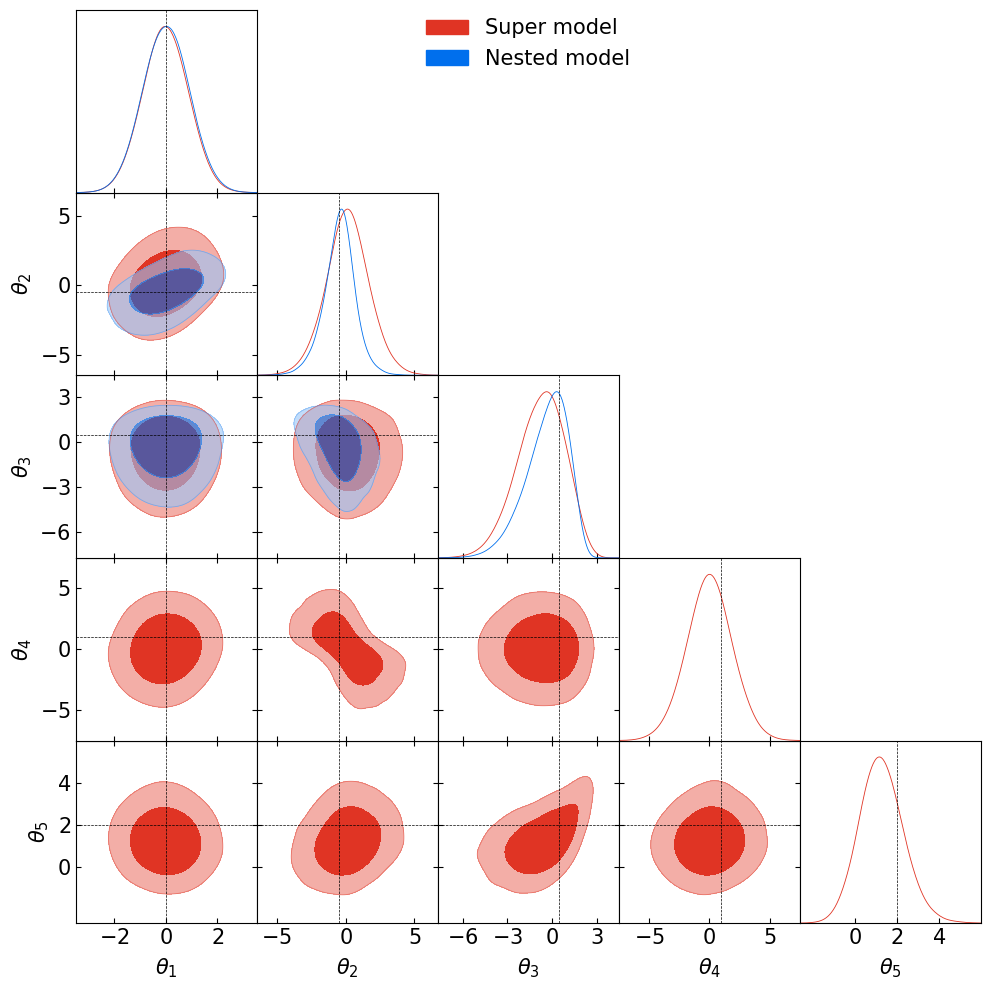

In [14]:
triangle_plot(
    [super_mc_samples, nested_mc_samples],
    truth=truth_marker)

## Now calculate the Savage Dickey Density Ratio for $\eta_1$ and $\eta_2$


In [15]:
marginalised_samples = super_samples[:, -n_nested:]
log_prior_prob = np.log(marginal_prior.pdf(eta_truth))

## We can calculate the SDDR with a histogram

In [16]:
histogram_model = hm.model_classical.HistogramModel(ndim=2, nbins=300)
histogram_sddr = hm.sddr.sddr(model=histogram_model, samples=marginalised_samples)
histogram_results = histogram_sddr.log_bayes_factor(log_prior=log_prior_prob,
                                                    value=eta_truth,
                                                    nbootstraps=100,
                                                    bootstrap_proportion=0.5,
                                                    bootstrap=True)

print(
    f"The Bayes factor calculated from the SDDR with the classical histogram model is: {histogram_results['log_bf']:.4f} \u00b1 {histogram_results['log_bf_std']:.4f}"
)

100%|██████████| 100/100 [00:02<00:00, 38.10it/s]

The Bayes factor calculated from the SDDR with the classical histogram model is: 0.9445 ± 0.2378


## We can calculate the SDDR by learning the marginal posterior with a flow

In [17]:
flow_model = hm.model.RQSplineModel(ndim_in=2, standardize=True, temperature=1.0)
flow_sddr = hm.sddr.sddr(model=flow_model, samples=marginalised_samples)
flow_results = flow_sddr.log_bayes_factor(log_prior=log_prior_prob,
                                          value=eta_truth,
                                          nbootstraps=10,
                                          bootstrap_proportion=0.5,
                                          bootstrap=True,
                                          epochs=10)
print(
    f"The Bayes factor calculated from the SDDR with the normalising flow model is: {flow_results['log_bf']:.4f} \u00b1 {flow_results['log_bf_std']:.4f}"
)

100%|██████████| 10/10 [09:24<00:00, 56.49s/it]

The Bayes factor calculated from the SDDR with the normalising flow model is: 0.9248 ± 0.0408


## Let's calculate evidence using nested sampling


In [18]:
nautilus_prior = Prior()

for i in range(n_params):
    nautilus_prior.add_parameter(
        f"theta_{i+1}", dist=norm(means[i], np.sqrt(prior_cov[i, i]))
    )


def nautilus_likelihood(param_dict):
    x = np.array([param_dict[f"theta_{i+1}"] for i in range(n_params)])
    ln_like = ln_likelihood(
        x, simulator=mock_simulator, data=noiseless_data, inv_cov=inv_cov
    )[0]
    return ln_like


sampler = Sampler(nautilus_prior, nautilus_likelihood, n_live=2000)
sampler.run(verbose=True)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 11     | 1        | 4        | 24500    | N/A    | 12213 | -2.99    


True

In [19]:
nested_nautilus_prior = Prior()
for i in range(n_params - n_nested):
    nested_nautilus_prior.add_parameter(
        f"theta_{i+1}", dist=norm(means[i], np.sqrt(prior_cov[i, i]))
    )


def nested_nautilus_likelihood(param_dict):
    x = np.array([param_dict[f"theta_{i+1}"] for i in range(n_params - n_nested)])
    ln_like = ln_likelihood(
        x, simulator=nested_mock_simulator, data=noiseless_data, inv_cov=inv_cov
    )[0]
    return ln_like


nested_sampler = Sampler(nested_nautilus_prior, nested_nautilus_likelihood, n_live=2000)
nested_sampler.run(verbose=True)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 10     | 1        | 4        | 21300    | N/A    | 10743 | -2.12    


True

In [20]:
print(
    f"The log evidence from Nautilus is: {sampler.log_z:.4f} \u00b1 {1/np.sqrt(sampler.n_eff):.4f}"
)
print(
    f"The log evidence for the nested model from Nautilus is: {nested_sampler.log_z:.4f} \u00b1 {1/np.sqrt(nested_sampler.n_eff):.4f}"
)
print(
    f"The Bayes factor from Nautilus is: {nested_sampler.log_z - sampler.log_z:.4f} \u00b1 {np.sqrt(1/sampler.n_eff + 1/nested_sampler.n_eff):.4f}"
)

The log evidence from Nautilus is: -2.9918 ± 0.0090
The log evidence for the nested model from Nautilus is: -2.1171 ± 0.0096
The Bayes factor from Nautilus is: 0.8747 ± 0.0132


## Repeat the evidence calculation but now using harmonic

### Configure some machine learning parameters


In [21]:
training_proportion = 0.5
temperature = 0.9
standardize = True
flow_type = "RQSpline"
epochs_num = 10

### Function to run harmonic


In [22]:
def run_harmonic(
    samples,
    log_prob,
    nparams,
    training_proportion,
    epochs_num,
    temperature,
    standardize,
):
    # ===================================================================
    # Configure emcee chains for harmonic
    # ===================================================================
    hm.logs.info_log("Configure chains...")
    """
    Configure chains for the cross-validation stage.
    """
    chains = hm.Chains(nparams)
    chains.add_chains_3d(samples, log_prob)
    chains_train, chains_test = hm.utils.split_data(
        chains, training_proportion=training_proportion
    )

    # =======================================================================
    # Fit model
    # =======================================================================
    hm.logs.info_log("Fit model for {} epochs...".format(epochs_num))
    model = hm.model.RQSplineModel(
        nparams, standardize=standardize, temperature=temperature
    )
    model.fit(chains_train.samples, epochs=epochs_num)

    # ===================================================================
    # Computing evidence using learnt model and emcee chains
    # ===================================================================
    hm.logs.info_log("Compute evidence...")
    """
    Instantiates the evidence class with a given model. Adds some chains 
    and computes the log-space evidence (marginal likelihood).
    """
    ev = hm.Evidence(chains_test.nchains, model)
    ev.add_chains(chains_test)
    ln_evidence, _ = ev.compute_ln_evidence()
    ln_evidence_err_neg, ln_evidence_err_pos = ev.compute_ln_inv_evidence_errors()

    return ln_evidence, ln_evidence_err_neg, ln_evidence_err_pos

In [23]:
chains = hm.Chains(n_params)
chains.add_chains_3d(harmonic_super_samples, harmonic_super_log_prob)

In [24]:
harmonic_ln_evidence, harmonic_ln_ev_err_neg, harmonic_ln_ev_err_pos = run_harmonic(
    samples=harmonic_super_samples,
    log_prob=harmonic_super_log_prob,
    nparams=n_params,
    training_proportion=training_proportion,
    epochs_num=epochs_num,
    temperature=temperature,
    standardize=standardize
    )

In [25]:
(
    harmonic_nested_ln_evidence,
    harmonic_nested_ln_ev_err_neg,
    harmonic_nested_ln_ev_err_pos,
) = run_harmonic(
    samples=harmonic_nested_samples,
    log_prob=harmonic_nested_log_prob,
    nparams=n_params - n_nested,
    training_proportion=training_proportion,
    epochs_num=epochs_num,
    temperature=temperature,
    standardize=standardize
    )

In [26]:
print(
    f"The log evidence from Harmonic is: {harmonic_ln_evidence:.4f} (+{harmonic_ln_ev_err_pos:.4f},{harmonic_ln_ev_err_neg:.4f})"
)
print(
    f"The log evidence for the nested model from Harmonic is: {harmonic_nested_ln_evidence:.4f} (+{harmonic_nested_ln_ev_err_pos:.4f},{harmonic_nested_ln_ev_err_neg:.4f})"
)
print(
    f"The log evidence ratio from Harmonic is: {harmonic_nested_ln_evidence - harmonic_ln_evidence:.4f} (+{np.sqrt(harmonic_nested_ln_ev_err_pos**2+harmonic_ln_ev_err_pos**2):.4f},-{np.sqrt(harmonic_nested_ln_ev_err_neg**2+harmonic_ln_ev_err_neg**2):.4f})"
)

The log evidence from Harmonic is: -3.0109 (+0.0024,-0.0024)
The log evidence for the nested model from Harmonic is: -2.1004 (+0.0016,-0.0016)
The log evidence ratio from Harmonic is: 0.9105 (+0.0028,-0.0028)


## The results in a table

| Method        | Log Evidence (Full Model) | Log Evidence (Nested Model) | Bayes Factor        |
| ------------- | ------------------------- | --------------------------- | ------------------- |
| Nautilus      | $-2.9918 \pm 0.0090$      | $-2.1171 \pm 0.0096$        | $0.8747 \pm 0.0132$ |
| Harmonic      | $-3.0109 \pm 0.0024$      | $-2.1004 \pm 0.0016$        | $0.9105 \pm 0.0028$ |
| Flow SDDR     | N/A                       | N/A                         | $0.9248 \pm 0.0408$ |
| Hist SDDR     | N/A                       | N/A                         | $0.9445 \pm 0.2378$ |